In [73]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import nltk
import matplotlib.pyplot as plt
from collections import Counter

nltk.download('rslp')
nltk.download('wordnet')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\grazi\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\grazi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [74]:
url_base = 'https://institucional.ufpel.edu.br'

In [75]:
# Get tittle and url of [count] projects
def getProjects(df, url, count):
    if count < 1:
        return df
    
    url = url + '/projetos'
    response = requests.get(url)
    url_list = []
    titles_list = []
    if response.status_code == 200:
        html = response.text

        soup = BeautifulSoup(html, 'html.parser')

        projects = soup.find_all('tbody')

        # get all "tr" tags
        projects = projects[0].find_all('tr')
        for p in projects[:count]:
            # url
            url_list.append(p.find('a').get('href'))
            # title
            titles_list.append(p.find('a').text)
        
        df['url'] = url_list
        df['title'] = titles_list
        return df

In [76]:
# Get information of projects
def getProjectsAbstract(df, url_base):
    urls = df['url']
    abstracts = []

    for url in urls:
        page = url_base + url
        response = requests.get(page)
        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, 'html.parser')
            
            # get project abstract
            description = soup.find('div', class_='ficha-dados cor-borda').text
            abstracts.append(description.split('Resumo')[1])

    df['abstract'] = abstracts
    return df

In [77]:
# Preprocess text functions
def normalize(df):
    df['abstract'] = df['abstract'].str.lower()
    return df

def remove_special_chars(df):
    df["abstract"] = df["abstract"].str.replace(r"[^a-zá-úãõâêîôûàèìòùç\s]", "", regex=True)
    return df

def tokenize(df):
    df['tokenized'] = df['abstract'].apply(nltk.word_tokenize)
    return df

def remove_stopwords(df):
    stop_words = set(nltk.corpus.stopwords.words('portuguese'))
    df['tokenized'] = df['tokenized'].apply(lambda x: [item for item in x if item not in stop_words])
    return df

def stem(df):
    stemmer = nltk.stem.RSLPStemmer()
    df['tokenized'] = df['tokenized'].apply(lambda x: [stemmer.stem(item) for item in x])
    return df

def lematize(df):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    df['tokenized'] = df['tokenized'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
    return df

In [83]:
# Plot unigrams and bigrams
def pipeline_to_str(pipeline):
    return ' -> '.join([step.__name__ for step in pipeline])

def plot_unigrams(df, column='tokenized', top_n=20, pipeline_key=None, pipeline=None):
    unigrams = Counter([word for tokens in df[column] for word in tokens])
    most_common = unigrams.most_common(top_n)
    
    words, counts = zip(*most_common)
    
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(f"Pipeline {pipeline_key}: " + pipeline_to_str(pipeline), fontsize=14)
    plt.xlabel("Unigramas", fontsize=14)
    plt.ylabel("Frequência", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_bigrams(df, column='tokenized', top_n=20, pipeline_key=None, pipeline=None):
    bigrams = Counter([(tokens[i], tokens[i+1]) for tokens in df[column] for i in range(len(tokens)-1)])
    most_common = bigrams.most_common(top_n)
    
    bigram_words, counts = zip(*most_common)
    bigram_labels = [' '.join(bigram) for bigram in bigram_words]
    
    plt.figure(figsize=(10, 6))
    plt.bar(bigram_labels, counts, color='lightgreen')
    plt.title(f"Pipeline {pipeline_key}: " + pipeline_to_str(pipeline), fontsize=14)
    plt.xlabel("Bigramas", fontsize=14)
    plt.ylabel("Frequência", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [84]:
df = pd.DataFrame()

df = getProjects(df, url_base, 100)
df = getProjectsAbstract(df, url_base)

print("Projects: ", df.shape[0])

Projects:  100


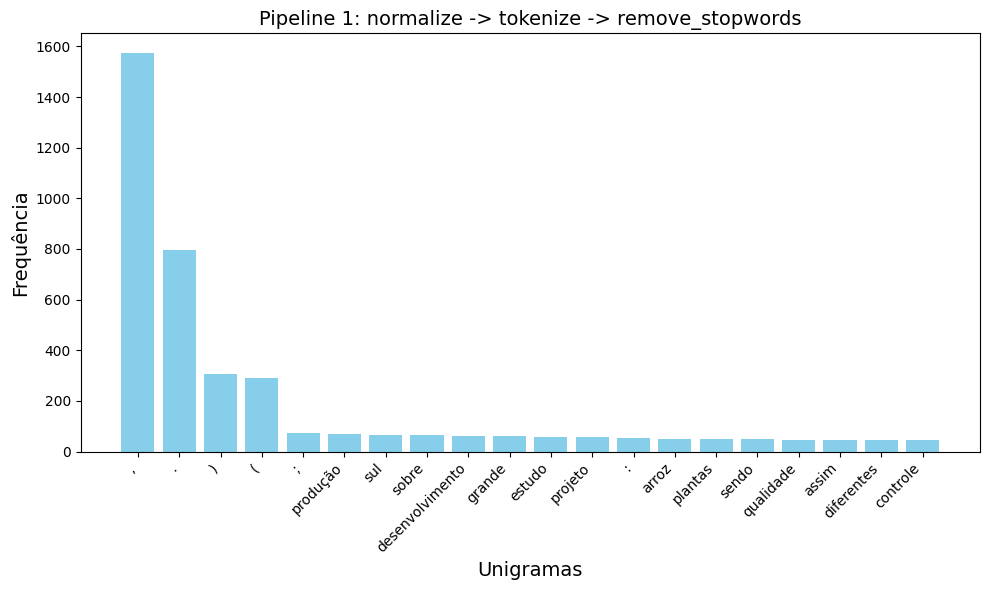

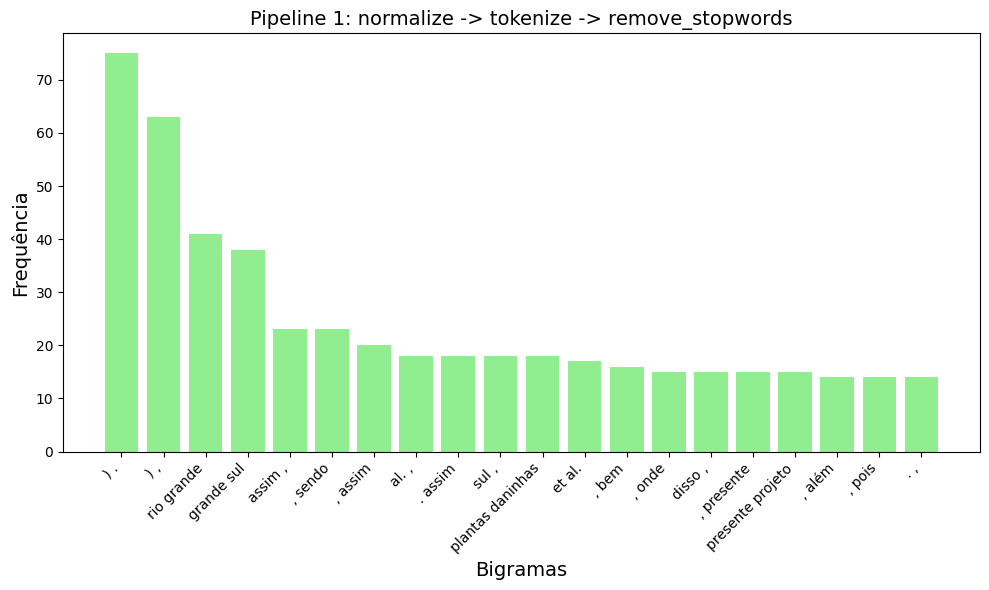

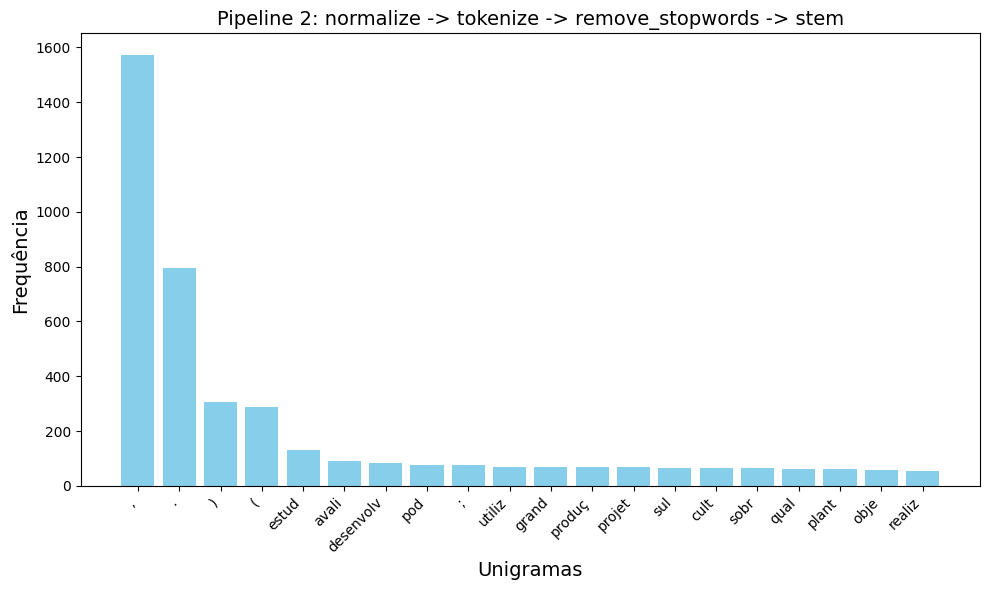

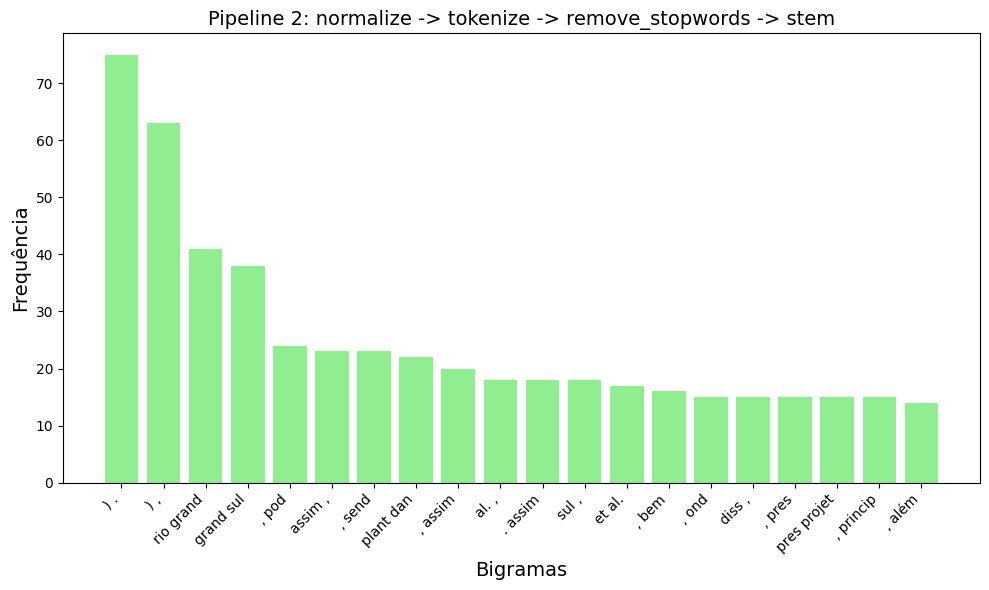

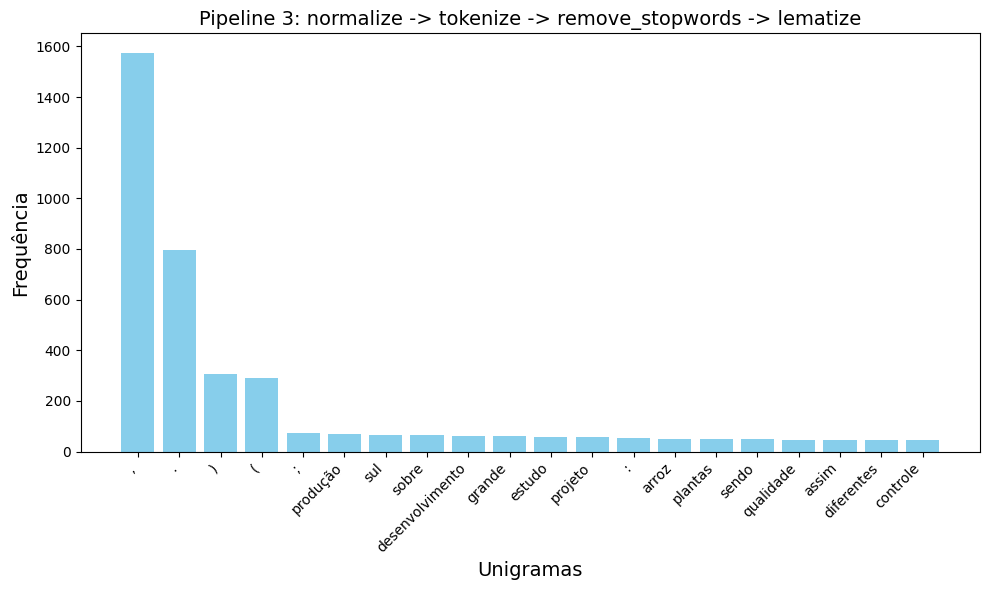

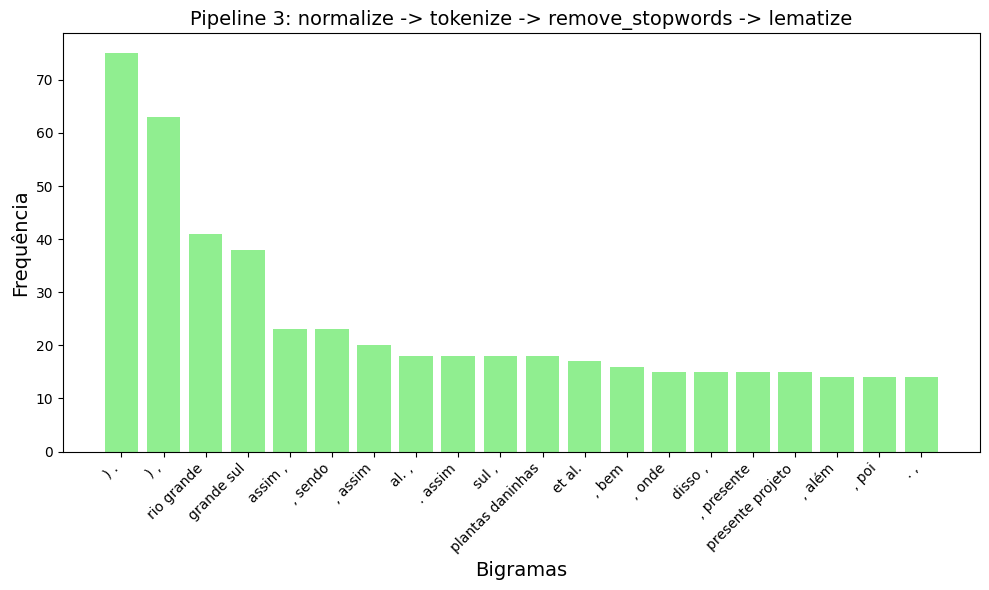

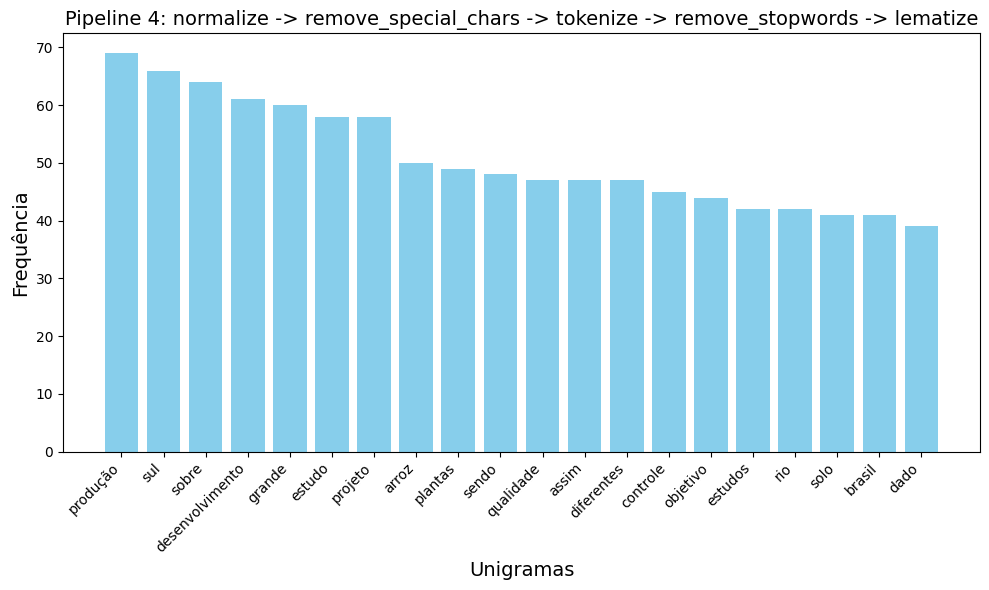

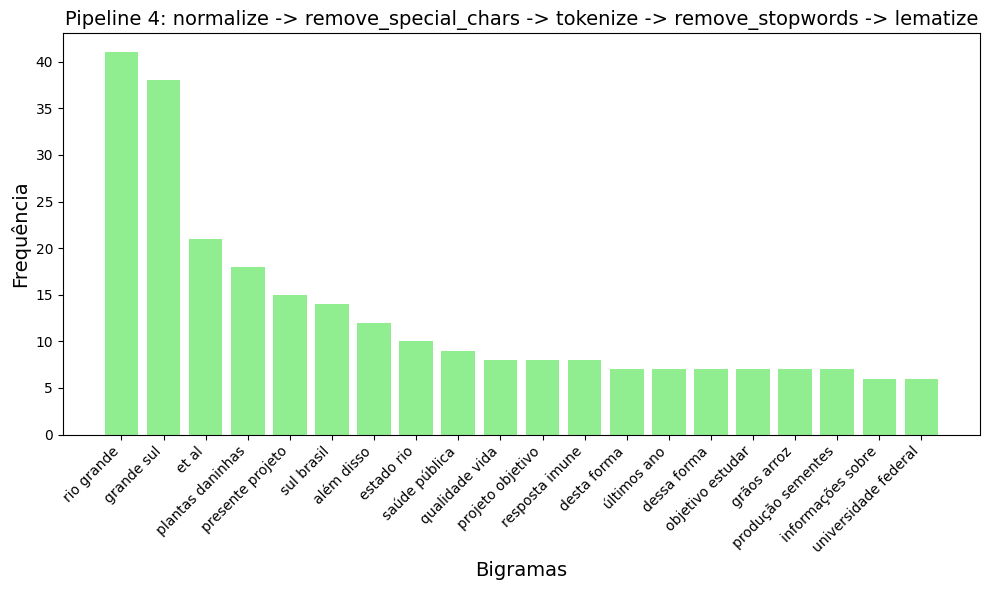

In [85]:
pipelines = {
    '1': [normalize, tokenize, remove_stopwords],
    '2': [normalize, tokenize, remove_stopwords, stem],
    '3': [normalize, tokenize, remove_stopwords, lematize],
    '4': [normalize, remove_special_chars, tokenize, remove_stopwords, lematize],
}

for key, pipeline in pipelines.items():
    df_copy = df.copy()
    for func in pipeline:
        df_copy = df_copy.pipe(func)

    plot_unigrams(df_copy, column='tokenized', top_n=20, pipeline_key=key, pipeline=pipeline)
    plot_bigrams(df_copy, column='tokenized', top_n=20, pipeline_key=key, pipeline=pipeline)